# Semesterarbeit Scientific Programming

## Libraries and settings

In [1]:
# Libraries
import os
import pandas as pd
import re
import sqlite3
import pycountry 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
import streamlit as st

## Auf Ordner zugreifen und daten in einem DF speichern

In [2]:
# Base path to archive Folder
base_path = 'archive'

# List of all seasonal folders in the archive
season_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

# sort folder by year  
season_folders.sort()

# For each season, load the Excel file and save it in a list of DataFrames
dataframes = []
for season in season_folders:
    file_path = os.path.join(base_path, season, 'champs.csv')
    df = pd.read_csv(file_path)
    df['season'] = season  # optional: add a new column "season" to save each season
    dataframes.append(df)

# Combine all Dataframes into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df)


                   Round                     Date  \
0        Round 1 | Leg 1   (Sun) 4 Sep 1955 (W35)   
1        Round 1 | Leg 1   (Wed) 7 Sep 1955 (W36)   
2        Round 1 | Leg 1   (Thu) 8 Sep 1955 (W36)   
3        Round 1 | Leg 1  (Wed) 14 Sep 1955 (W37)   
4        Round 1 | Leg 1  (Tue) 20 Sep 1955 (W38)   
...                  ...                      ...   
6549  Semifinals | Leg 1  (Tue) 26 Apr 2016 (W17)   
6550  Semifinals | Leg 1  (Wed) 27 Apr 2016 (W17)   
6551  Semifinals | Leg 2   (Tue) 3 May 2016 (W18)   
6552  Semifinals | Leg 2   (Wed) 4 May 2016 (W18)   
6553               Final  (Sat) 28 May 2016 (W21)   

                                Team 1       FT   HT  \
0                Sporting CP › POR (1)      3-3  1-1   
1     Budapesti Voros Lobogo › HUN (1)      6-3  3-2   
2            Servette Geneve › SUI (1)      0-2  0-0   
3            Rot-Weiss Essen › GER (1)      0-4  0-2   
4             Djurgardens IF › SWE (1)      0-0  0-0   
...                        

## "Group" und "Comments" entfernen

In [3]:
# List of columns to be removed
columns_to_drop = ['Comments', 'Stage']

# Removing the columns from the DataFrame
combined_df = combined_df.drop(columns=columns_to_drop)

print(combined_df.head())

             Round                     Date                            Team 1  \
0  Round 1 | Leg 1   (Sun) 4 Sep 1955 (W35)             Sporting CP › POR (1)   
1  Round 1 | Leg 1   (Wed) 7 Sep 1955 (W36)  Budapesti Voros Lobogo › HUN (1)   
2  Round 1 | Leg 1   (Thu) 8 Sep 1955 (W36)         Servette Geneve › SUI (1)   
3  Round 1 | Leg 1  (Wed) 14 Sep 1955 (W37)         Rot-Weiss Essen › GER (1)   
4  Round 1 | Leg 1  (Tue) 20 Sep 1955 (W38)          Djurgardens IF › SWE (1)   

    FT   HT                       Team 2  ∑FT   ET    P   season Group  
0  3-3  1-1  Partizan Belgrade › SRB (1)  NaN  NaN  NaN  1955-56   NaN  
1  6-3  3-2     RSC Anderlecht › BEL (1)  NaN  NaN  NaN  1955-56   NaN  
2  0-2  0-0     Real Madrid CF › ESP (1)  NaN  NaN  NaN  1955-56   NaN  
3  0-4  0-2       Hibernian FC › SCO (1)  NaN  NaN  NaN  1955-56   NaN  
4  0-0  0-0   Gwardia Warszawa › POL (1)  NaN  NaN  NaN  1955-56   NaN  


## Einträge unter FT und ET & P Checken

In [4]:
# Function to check whether a string corresponds to the format "0-0"
def check_format(s):
    if pd.isna(s):
        return True
    else:
        return bool(re.match(r'^\d+-\d+$', s))

# Set for storing unique invalid formats
invalid_formats_FT = set()
invalid_formats_ET = set()
invalid_formats_P = set()

# Check all entries in the "FT" columns
for i, row in combined_df.iterrows():
    if not check_format(row['FT']):
        # Remove numbers and hyphens
        cleaned_format = re.sub(r'[\d-]', '', row['FT']).strip()
        invalid_formats_FT.add(cleaned_format)

# Check all entries in the "ET" column
for i, row in combined_df.iterrows():
    if not check_format(row['ET']):
        # Remove numbers and hyphens
        cleaned_format = re.sub(r'[\d-]', '', row['ET']).strip()
        invalid_formats_ET.add(cleaned_format)

# Check all entries in the "P" column
for i, row in combined_df.iterrows():
    if not check_format(row['P']):
        # Remove numbers and hyphens
        cleaned_format = re.sub(r'[\d-]', '', row['P']).strip()
        invalid_formats_P.add(cleaned_format)

# Print the unique invalid formats
for format in invalid_formats_FT:
    print(f"Ivalid format in FT: 0-0 {format}")

# Print the unique invalid formats
for format in invalid_formats_ET:
    print(f"Ivalid format in ET: 0-0 {format}")

# Print the unique invalid formats
for format in invalid_formats_P:
    print(f"Ivalid format in P: 0-0 {format}")

Ivalid format in FT: 0-0 (*)
Ivalid format in ET: 0-0 (a.e.t.)
Ivalid format in P: 0-0 (pen.)


## Neue Zeile für Verlängerung

In [5]:
def check_overtime(row):
    overtime = 'no'
    # Edit the "FT" column
    if re.search(r'\(\*\)', row['FT']):
        row['FT'] = re.sub(r' \(\*\)', '', row['FT'])
        overtime = 'yes'
    
    # Edit the "ET" column
    if pd.notna(row['ET']) and re.search(r' \(a\.e\.t\.\)', row['ET']):
        row['ET'] = re.sub(r' \(a\.e\.t\.\)', '', row['ET'])
        overtime = 'yes'
    
    # Edit the "P" column
    if pd.notna(row['P']) and re.search(r' \(pen\.\)', row['P']):
        row['P'] = re.sub(r' \(pen\.\)', '', row['P'])
        overtime = 'penalty'
    
    return overtime

# Update the columns "FT", "ET", and "P" and create the new column "Extra Time"
combined_df['Overtime'] = combined_df.apply(check_overtime, axis=1)
print(combined_df.head())

             Round                     Date                            Team 1  \
0  Round 1 | Leg 1   (Sun) 4 Sep 1955 (W35)             Sporting CP › POR (1)   
1  Round 1 | Leg 1   (Wed) 7 Sep 1955 (W36)  Budapesti Voros Lobogo › HUN (1)   
2  Round 1 | Leg 1   (Thu) 8 Sep 1955 (W36)         Servette Geneve › SUI (1)   
3  Round 1 | Leg 1  (Wed) 14 Sep 1955 (W37)         Rot-Weiss Essen › GER (1)   
4  Round 1 | Leg 1  (Tue) 20 Sep 1955 (W38)          Djurgardens IF › SWE (1)   

    FT   HT                       Team 2  ∑FT   ET    P   season Group  \
0  3-3  1-1  Partizan Belgrade › SRB (1)  NaN  NaN  NaN  1955-56   NaN   
1  6-3  3-2     RSC Anderlecht › BEL (1)  NaN  NaN  NaN  1955-56   NaN   
2  0-2  0-0     Real Madrid CF › ESP (1)  NaN  NaN  NaN  1955-56   NaN   
3  0-4  0-2       Hibernian FC › SCO (1)  NaN  NaN  NaN  1955-56   NaN   
4  0-0  0-0   Gwardia Warszawa › POL (1)  NaN  NaN  NaN  1955-56   NaN   

  Overtime  
0       no  
1       no  
2       no  
3       no  
4  

## Neue Spalte für einzelne Tore

In [6]:
def get_goals(row):
    for col in ['P', 'ET', 'FT']:
        if pd.notna(row[col]):
            return row[col].split('-')

combined_df[['goals_hometeam', 'goals_guestteam']] = combined_df.apply(get_goals, axis=1, result_type='expand').astype(int)
print(combined_df.head())

             Round                     Date                            Team 1  \
0  Round 1 | Leg 1   (Sun) 4 Sep 1955 (W35)             Sporting CP › POR (1)   
1  Round 1 | Leg 1   (Wed) 7 Sep 1955 (W36)  Budapesti Voros Lobogo › HUN (1)   
2  Round 1 | Leg 1   (Thu) 8 Sep 1955 (W36)         Servette Geneve › SUI (1)   
3  Round 1 | Leg 1  (Wed) 14 Sep 1955 (W37)         Rot-Weiss Essen › GER (1)   
4  Round 1 | Leg 1  (Tue) 20 Sep 1955 (W38)          Djurgardens IF › SWE (1)   

    FT   HT                       Team 2  ∑FT   ET    P   season Group  \
0  3-3  1-1  Partizan Belgrade › SRB (1)  NaN  NaN  NaN  1955-56   NaN   
1  6-3  3-2     RSC Anderlecht › BEL (1)  NaN  NaN  NaN  1955-56   NaN   
2  0-2  0-0     Real Madrid CF › ESP (1)  NaN  NaN  NaN  1955-56   NaN   
3  0-4  0-2       Hibernian FC › SCO (1)  NaN  NaN  NaN  1955-56   NaN   
4  0-0  0-0   Gwardia Warszawa › POL (1)  NaN  NaN  NaN  1955-56   NaN   

  Overtime  goals_hometeam  goals_guestteam  
0       no            

## Heim und Auswärtssiege zählen

In [7]:
home_wins = 0
away_wins = 0

for index, row in combined_df.iterrows():
    if row['goals_hometeam'] > row['goals_guestteam']:
        home_wins += 1
    elif row['goals_guestteam'] > row['goals_hometeam']:
        away_wins += 1

wins_dict = {'home_wins': home_wins, 'away_wins': away_wins}
print(wins_dict)

{'home_wins': 3527, 'away_wins': 1650}


## SQLite Datenbank erstellen

In [8]:
# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('ChampionsLeague.db')

# Create a cursor object
c = conn.cursor()

# Create table - countries
c.execute('''
    CREATE TABLE IF NOT EXISTS countries (
        id INTEGER PRIMARY KEY,
        code TEXT,
        name TEXT
    )
''')

# Create table - teams
c.execute('''
    CREATE TABLE IF NOT EXISTS teams (
        team VARCHAR(255),
        country_id INTEGER,
        won_games INTEGER,
        won_titles INTEGER,
        played_games INTEGER,
        FOREIGN KEY(country_id) REFERENCES countries(id)
    )
''')

# Commit the changes and close the connection
conn.commit()
conn.close()

## Länder auslesen

In [9]:
# Extract the countries from the "Team 1" and "Team 2" columns
countries_team1 = combined_df['Team 1'].str.slice(-7, -4)
countries_team2 = combined_df['Team 2'].str.slice(-7, -4)

# Combine the two series into one DataFrame
countries = pd.concat([countries_team1, countries_team2]).to_frame(name='code')

# Remove duplicates
countries = countries.drop_duplicates()

# Add an "id" column
countries = countries.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})

# The "id" column should start with 1, not 0
countries['id'] = countries['id'] + 1

def country_code_to_name(code):
    try:
        return pycountry.countries.get(alpha_3=code).name
    except AttributeError:
        return 'nan'

countries['name'] = countries['code'].apply(country_code_to_name)

print(countries)

    id code       name
0    1  POR        nan
1    2  HUN    Hungary
2    3  SUI        nan
3    4  GER        nan
4    5  SWE     Sweden
..  ..  ...        ...
79  80  GIB  Gibraltar
80  81  VN         nan
81  82  AZ         nan
82  83  OL         nan
83  84  IN         nan

[84 rows x 3 columns]


## Teamstabelle erstellen

In [10]:
CL_kopie = combined_df.copy()

# Extract country code from team names
CL_kopie['code_team1'] = CL_kopie['Team 1'].str.extract('› (\w{3}) ')[0]
CL_kopie['code_team2'] = CL_kopie['Team 2'].str.extract('› (\w{3}) ')[0]

# Extract team names from the 'Team 1' and 'Team 2' columns
CL_kopie['Team 1'] = CL_kopie['Team 1'].str.extract('(.*) ›')[0]
CL_kopie['Team 2'] = CL_kopie['Team 2'].str.extract('(.*) ›')[0]

# Extracting the unique team names and associated country codes
teams1 = CL_kopie[['Team 1', 'code_team1']].rename(columns={'Team 1': 'team', 'code_team1': 'code'}).drop_duplicates()
teams2 = CL_kopie[['Team 2', 'code_team2']].rename(columns={'Team 2': 'team', 'code_team2': 'code'}).drop_duplicates()
teams = pd.concat([teams1, teams2]).drop_duplicates()

# Replace the country codes with the corresponding IDs from the country table and adjust the table
teams['code'] = teams['code'].map(countries.set_index('code')['id'])
teams.rename(columns={'code': 'country_id'}, inplace=True)

# Count the games for each team
team1_games = CL_kopie['Team 1'].value_counts()
team2_games = CL_kopie['Team 2'].value_counts()

# Total the games for each team
total_games = team1_games.add(team2_games, fill_value=0)

# Add the games played to the "teams" DataFrame
teams['played_games'] = teams['team'].map(total_games)

# Count the number of wins for each team
won_games = CL_kopie['Team 1'][CL_kopie['goals_hometeam'] > CL_kopie['goals_guestteam']].value_counts()
won_games += CL_kopie['Team 2'][CL_kopie['goals_hometeam'] < CL_kopie['goals_guestteam']].value_counts()

# Add the games won to the teams table
teams['won_games'] = teams['team'].map(won_games).fillna(0)

# Filter final games
finals_df = CL_kopie[CL_kopie['Round'].str.contains('Final', na=False)]

# Count the number of titles won for each team
won_titles_team1 = finals_df['Team 1'][finals_df['goals_hometeam'] > finals_df['goals_guestteam']].value_counts()
won_titles_team2 = finals_df['Team 2'][finals_df['goals_guestteam'] < finals_df['goals_hometeam']].value_counts()

# Total the titles for each team
won_titles = won_titles_team1.add(won_titles_team2, fill_value=0)

# Add the titles won to the teams table
teams['won_titles'] = teams['team'].map(won_titles).fillna(0)

print(teams)


                        team  country_id  played_games  won_games  won_titles
0                Sporting CP           1            78       22.0         0.0
1     Budapesti Voros Lobogo           2             4        2.0         0.0
2            Servette Geneve           3            21        6.0         0.0
3            Rot-Weiss Essen           4             2        0.0         0.0
4             Djurgardens IF           5            16        4.0         0.0
...                      ...         ...           ...        ...         ...
6352             Midtjylland           7             4        3.0         0.0
6365               Dila Gori          39             2        0.0         0.0
6368           Milsami Orhei          56             4        2.0         0.0
6372                  Astana          67            12        0.0         0.0
6374                Stjarnan          32             2        0.0         0.0

[501 rows x 5 columns]


## Zu SQL hinzufügen

In [11]:
# Establish a connection to your SQLite database
connection = sqlite3.connect('ChampionsLeague.db')
cursor = connection.cursor()

# Insert data from the DataFrames into the SQLite database
for _, row in countries.iterrows():
    cursor.execute(f"INSERT INTO {'countries'} ({', '.join(countries.columns)}) VALUES (?, ?, ?)", row)

for _, row in teams.iterrows():
    cursor.execute(f"INSERT INTO {'teams'} ({', '.join(teams.columns)}) VALUES (?, ?, ?, ?, ?)", row)

# Commit the changes and close the connection
connection.commit()
connection.close()

## SQL Abfragen erstellen und in dataFrame sowie CSV speichern

In [12]:
def get_teams_data(country_codes):
    # Connect to the SQLite database
    connection = sqlite3.connect('ChampionsLeague.db')

    dfs = {}
    for code in country_codes:
        # Execute SQL query and save the result in a DataFrame
        query = f"SELECT team, won_games, played_games, won_titles FROM teams JOIN countries ON teams.country_id = countries.id WHERE countries.code = '{code}' ORDER BY played_games DESC"
        df = pd.read_sql_query(query, connection)
        
        # Sort Dataframe and insert it into the dictionary
        df = df.sort_values('played_games', ascending=False)
        dfs[code] = df

    # Close connection
    connection.close()
    
    return dfs

# List of country codes
country_codes = ['SUI', 'ESP']

# Obtaining the DataFrames
dataframes = get_teams_data(country_codes)

# Saving the DataFrames in separate CSV files
for code, df in dataframes.items():
    df.to_csv(f'{code}_teams.csv', index=False)

# Creat an ExcelWriter object
with pd.ExcelWriter('teams_data.xlsx') as writer:
    # Go through the dictionary of DataFrames
    for code, df in dataframes.items():
        # Write each DataFrame in a separate worksheet
        df.to_excel(writer, sheet_name=code, index=False)

## Klasse SeasonStats hinzufügen

In [13]:
class SeasonStats:
    def __init__(self, df, season):
        self.df = df[df['season'] == season]
        self.season = season

    def plot_wins_per_team(self, top_teams=20):
        # Determine the winner of each game
        df = self.df.copy()
        df['Team 1'] = df['Team 1'].str.extract('(.*) ›')[0]
        df['Team 2'] = df['Team 2'].str.extract('(.*) ›')[0]

        # Count the number of wins for each team
        won_games_team1 = df['Team 1'][df['goals_hometeam'] > df['goals_guestteam']].value_counts()
        won_games_team2 = df['Team 2'][df['goals_hometeam'] < df['goals_guestteam']].value_counts()

        # Total the wins for each team
        won_games = won_games_team1.add(won_games_team2, fill_value=0)
        
        # Keep only the top teams
        won_games = won_games.head(top_teams)

        # Sort in ascending order by number of wins
        won_games = won_games.sort_values()

        print(won_games.head())

        # Creates the bar-chart
        plt.figure(figsize=(20,6))
        plt.bar(won_games.index, won_games.values)
        plt.title(f'Top {top_teams} Teams with the most wins in season {self.season}')
        plt.xlabel('Teams')
        plt.ylabel('Number of wins')
        plt.xticks(rotation=90)
        plt.show()


    def plot_goal_distribution(self):
        # Counts the goals per game in the season
        goals = self.df['goals_hometeam'] + self.df['goals_guestteam']

        # Creates the histogramm
        plt.figure(figsize=(10,6))
        plt.hist(goals, bins=11, edgecolor='black')
        plt.title(f'Distribution of goals per game in the season {self.season}', fontsize=16)
        plt.xlabel('Goals per game', fontsize=12)
        plt.ylabel('Number of games', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        plt.show()

## Klasse SeasonStats aufrufen für Visualisierungen

AEL Limassol    1.0
AFC Ajax        1.0
CSKA Moskva     1.0
AS Roma         1.0
Aalborg BK      1.0
dtype: float64


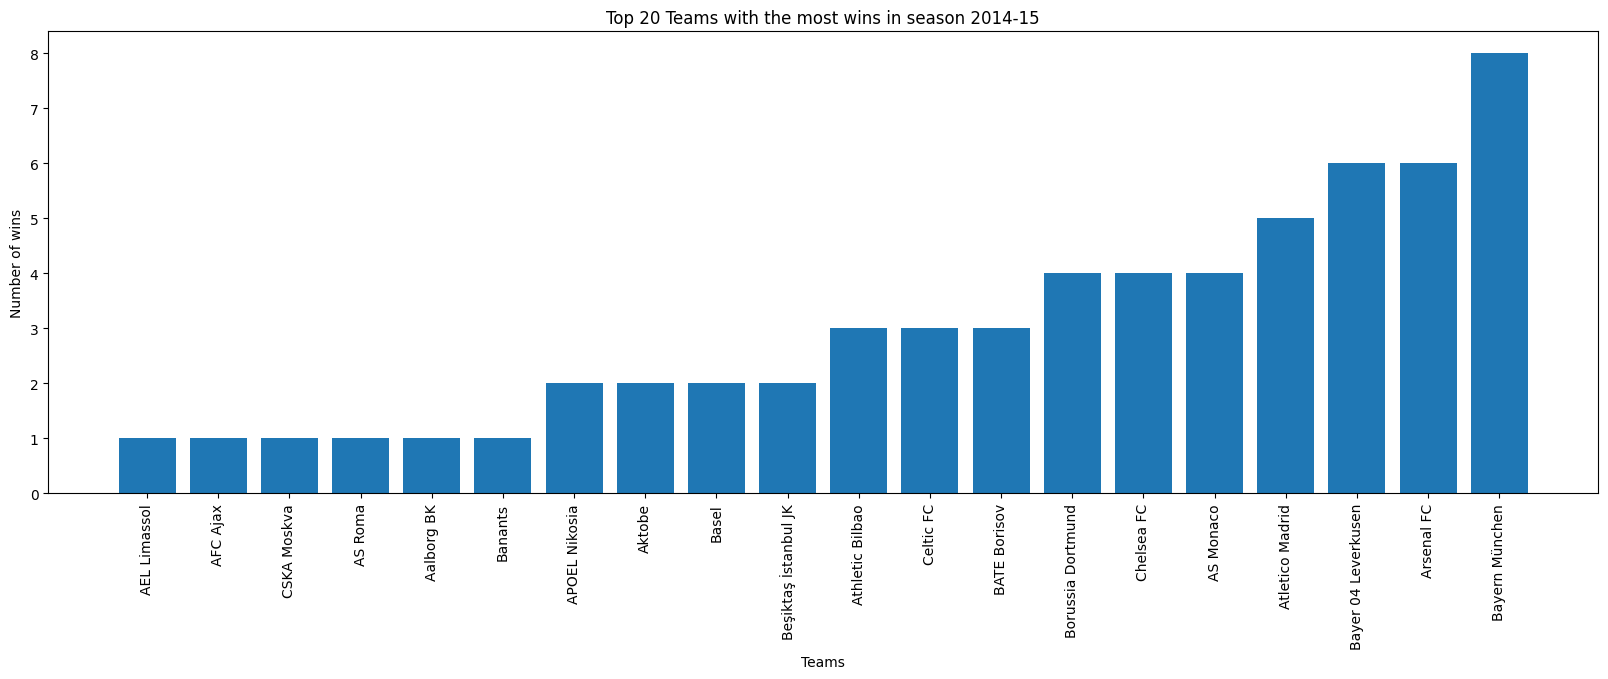

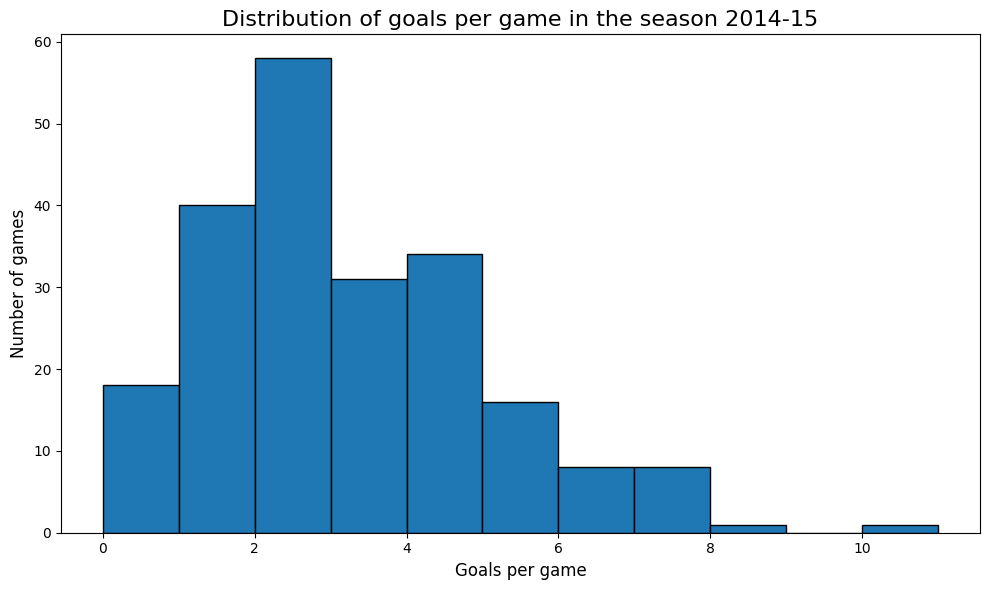

In [14]:
season_2020 = SeasonStats(combined_df, '2014-15')
season_2020.plot_wins_per_team()
season_2020.plot_goal_distribution()

## Korrelation zwischen gespielten Spielen und gewonnen Spielen

In [15]:
# Calculation of the correlation
correlation = teams['played_games'].corr(teams['won_games'])

print(f"The correlation between the number of played games and the number of won games is: {correlation}")

The correlation between the number of played games and the number of won games is: 0.9776076090543319


In [16]:
# Divide the data into two groups
group1 = teams[teams['country_id'] == 10]['won_games']
group2 = teams[teams['country_id'] == 3]['won_games']

# Perform the t-test
t_statistic, p_value = ttest_ind(group1, group2)

print(f"The t-test gives a t-value of {t_statistic} and a p-value of {p_value}")


The t-test gives a t-value of 1.8316056382832047 and a p-value of 0.07849178531527767


## Top 10 Teams mit den meisten Siegen 

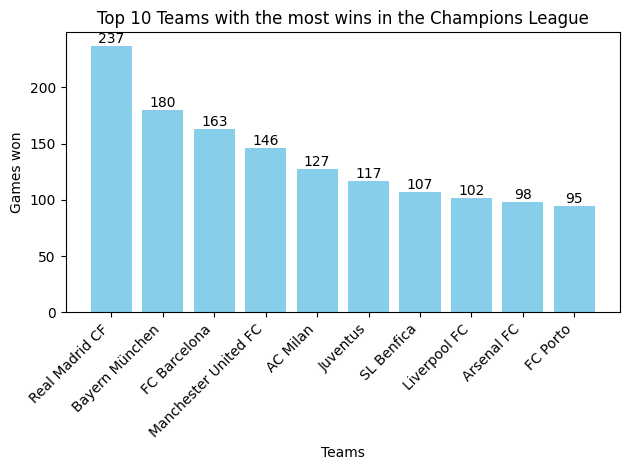

In [17]:
# Connect to the SQLite database
conn = sqlite3.connect('ChampionsLeague.db')
cursor = conn.cursor()

# Execute the SQL query
cursor.execute("SELECT team, won_games FROM teams ORDER BY won_games DESC LIMIT 10")
results = cursor.fetchall()

# Separate the results into separate lists
teams = [row[0] for row in results]
gewonnene_spiele = [row[1] for row in results]

# Create the bar chart
fig, ax = plt.subplots()
bar_plot = ax.bar(teams, gewonnene_spiele, color='skyblue')

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

# Set the axis labels and chart title
ax.set_xlabel('Teams')
ax.set_ylabel('Games won')
ax.set_title('Top 10 Teams with the most wins in the Champions League')

# Automatically adjust layout padding
plt.tight_layout()

# Display value labels inside the bars
for rect in bar_plot:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, height,
            ha='center', va='bottom')

# Display the chart
plt.show()



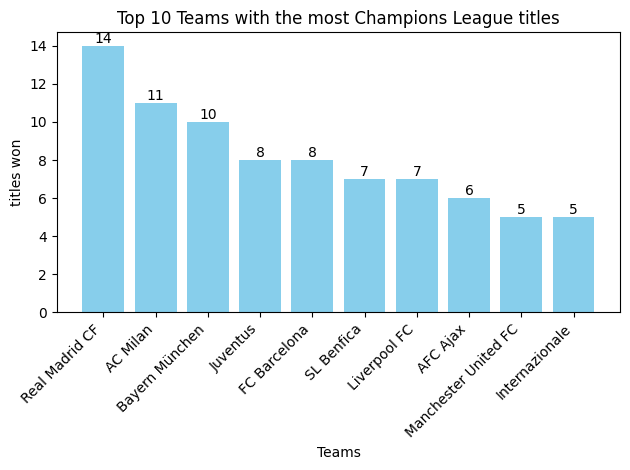

In [18]:
# Connect to the SQLite database
conn = sqlite3.connect('ChampionsLeague.db')
cursor = conn.cursor()

# Execute the SQL query
cursor.execute("SELECT team, won_titles FROM teams ORDER BY won_titles DESC LIMIT 10")
results = cursor.fetchall()

# Separate the results into separate lists
teams = [row[0] for row in results]
gewonnene_titel = [row[1] for row in results]

# Create the bar chart
fig, ax = plt.subplots()
bar_plot = ax.bar(teams, gewonnene_titel, color='skyblue')

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

# Set the axis labels and chart title
ax.set_xlabel('Teams')
ax.set_ylabel('titles won')
ax.set_title('Top 10 Teams with the most Champions League titles')

# Automatically adjust layout padding
plt.tight_layout()

# Display value labels inside the bars
for rect in bar_plot:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, height,
            ha='center', va='bottom')

# Display the chart
plt.show()

# Close the database connection
cursor.close()
conn.close()

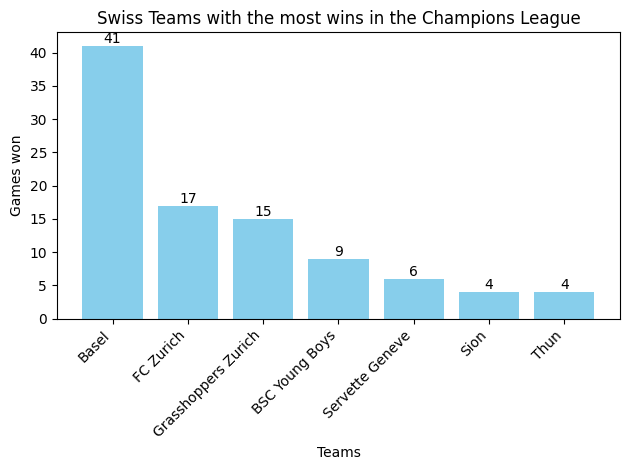

In [19]:
# Connect to the SQLite database
conn = sqlite3.connect('ChampionsLeague.db')
cursor = conn.cursor()

# Execute the SQL query
cursor.execute("SELECT team, won_games FROM teams WHERE country_id = 3 ORDER BY won_games DESC LIMIT 7")
results = cursor.fetchall()

# Separate the results into separate lists
teams = [row[0] for row in results]
gewonnene_spiele = [row[1] for row in results]

# Create the bar chart
fig, ax = plt.subplots()
bar_plot = ax.bar(teams, gewonnene_spiele, color='skyblue')

# Set the axis labels and chart title
ax.set_xlabel('Teams')
ax.set_ylabel('Games won')
ax.set_title('Swiss Teams with the most wins in the Champions League')

# Display value labels inside the bars
for rect in bar_plot:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, height,
            ha='center', va='bottom')

# Rotate and align the x-axis labels
plt.xticks(rotation=45, ha='right')

# Automatically adjust layout padding
plt.tight_layout()

# Display the chart
plt.show()

# Close the database connection
cursor.close()
conn.close()


## Footer

In [20]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2023-05-26 12:49:27
Python Version: 3.10.9
-----------------------------------
